# Partisan Lean of Content
20DEC2020<br>
Richard Kuzma and Iain Cruickshank


### Imports

In [1]:
import pandas as pd, numpy as np, pickle, time, re


from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import math

In [2]:
from sklearn.decomposition import PCA, KernelPCA

import seaborn as sns
from sklearn.metrics import classification_report, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import SilhouetteVisualizer




#### Load Tweet Data

In [3]:
src_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/'
load_name = 'anti_vax_tweets_urls_articles_labels_10k.pkl'

with open(src_path + load_name, 'rb') as f:
    tweets = pickle.load(f)

# tweets.drop(columns='partisan_lean', inplace=True)
print(tweets.columns)
tweets.head()



Index(['created_at', 'id_str', 'entities', 'user', 'retweet_count',
       'favorite_count', 'retweeted_status', 'Hash words', 'link', 'urls',
       'first_url', 'url_total_retweets', 'url_total_favorites',
       'article_text', 'article_text_preprocessed', 'domain', 'news',
       'science', 'govt', 'dubious', 'not_any', 'news_plus_science',
       'science_plus_dubious', 'news_plus_dubious', 'group', 'month', 'no_www',
       'lean_not_known', 'lean_left', 'lean_center', 'lean_right',
       'partisan_lean', 'fake_news', 'conspiracy', 'bias'],
      dtype='object')


,created_at,id_str,entities,user,retweet_count,favorite_count,retweeted_status,Hash words,link,urls,...,month,no_www,lean_not_known,lean_left,lean_center,lean_right,partisan_lean,fake_news,conspiracy,bias
0,2020-01-24 16:02:16+00:00,1.220739e+18,"{'hashtags': [{'text': 'vaccine', 'indices': [...","{'id': 1929460038, 'id_str': '1929460038', 'na...",3.0,8.0,NaN,#vaccine #vaccine #coronavirus. #wuhan #davos,https://twitter.com/user/status/12207385956628...,[https://www.eurekalert.org/pub_releases/2020-...,...,01,eurekalert.org,1,0,0,0,2,0,0,4
1,2020-01-24 16:52:18+00:00,1.220751e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 339740849, 'id_str': '339740849', 'name...",0.0,4.0,NaN,No hashtags,https://twitter.com/user/status/12207511874791...,[https://www.cdc.gov/mmwr/volumes/68/wr/mm6809...,...,01,cdc.gov,1,0,0,0,2,0,0,4
2,2020-01-24 16:50:00+00:00,1.220751e+18,"{'hashtags': [{'text': 'FightFlu', 'indices': ...","{'id': 753312146734346240, 'id_str': '75331214...",2.0,2.0,NaN,#fightflu:,https://twitter.com/user/status/12207506089713...,[https://www.cdc.gov/flu/resource-center/index...,...,01,cdc.gov,1,0,0,0,2,0,0,4
3,2020-01-24 16:40:00+00:00,1.220748e+18,"{'hashtags': [{'text': 'FluShotFriday', 'indic...","{'id': 753318075886338048, 'id_str': '75331807...",0.0,1.0,NaN,#flushotfriday,https://twitter.com/user/status/12207480921835...,[https://go.usa.gov/xVn4Y],...,01,go.usa.gov,1,0,0,0,2,0,0,4
4,2020-01-24 16:26:00+00:00,1.220745e+18,"{'hashtags': [{'text': 'cancer', 'indices': [2...","{'id': 557670851, 'id_str': '557670851', 'name...",2.0,2.0,NaN,#cancer: #hepatitisc #hpv,https://twitter.com/user/status/12207445691861...,[https://www.cdc.gov/cancer/dcpc/prevention/in...,...,01,cdc.gov,1,0,0,0,2,0,0,4


#### Load Domain Information

In [4]:
src_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/'
load_name = 'domain_info.csv'

domain_info = pd.read_csv(src_path + load_name)

print(domain_info.shape)
domain_info.head()

(3037, 4)


,Domain,Rating,Bias,Factual_Rating
0,100percentfedup.com,red,fake-news,very low
1,10news.one,unknown,fake-news,very low
2,12minutos.com,black,black,black
3,180report.com,unknown,center,mixed
4,20minutenews.com,black,unknown,unknown


In [5]:
domain_info['Bias'].value_counts()

fake-news       533
left-center     494
center          432
left            333
conspiracy      299
right           279
unknown         277
right-center    249
pro-science     140
black             1
Name: Bias, dtype: int64

#### Label Partisan Lean of Tweets

In [6]:
# label domains by partisan lean (left, center, right)
right_lean_domains = domain_info[(domain_info['Bias'] == 'right') | (domain_info['Bias'] == 'right-center')]['Domain'].tolist()
left_lean_domains = domain_info[(domain_info['Bias'] == 'left') | (domain_info['Bias'] == 'left-center')]['Domain'].tolist()
center_lean_domains = domain_info[(domain_info['Bias'] == 'center')]['Domain'].tolist()
fake_news_domains = domain_info[(domain_info['Bias'] == 'fake-news')]['Domain'].tolist()
conspiracy_domains = domain_info[(domain_info['Bias'] == 'conspiracy')]['Domain'].tolist()

any_lean_domains = right_lean_domains + left_lean_domains + center_lean_domains + fake_news_domains + conspiracy_domains

def label_partisan(df):
    df['no_www'] = df['domain'].apply(lambda x: re.search(r"(www.)?(.*)", x).group(2))
    df['fake_news'] = df['no_www'].apply(lambda x: 1 if x in fake_news_domains else 0)
    df['conspiracy'] = df['no_www'].apply(lambda x: 1 if x in conspiracy_domains else 0)
    df['lean_left'] = df['no_www'].apply(lambda x: 1 if x in left_lean_domains else 0)
    df['lean_center'] = df['no_www'].apply(lambda x: 1 if x in center_lean_domains else 0)
    df['lean_right'] = df['no_www'].apply(lambda x: 1 if x in right_lean_domains else 0)
    df['lean_not_known'] = df['no_www'].apply(lambda x: 1 if x not in any_lean_domains else 0) 

    return df

tweets = label_partisan(tweets)
tweets['bias'] = (tweets.loc[:, ['fake_news', 'conspiracy', 'lean_left', 'lean_center', 'lean_right', 'lean_not_known']] == 1).idxmax(1).astype('category').cat.codes
tweets.reset_index(drop=True, inplace=True)

In [7]:
tweets.head()

,created_at,id_str,entities,user,retweet_count,favorite_count,retweeted_status,Hash words,link,urls,...,month,no_www,lean_not_known,lean_left,lean_center,lean_right,partisan_lean,fake_news,conspiracy,bias
0,2020-01-24 16:02:16+00:00,1.220739e+18,"{'hashtags': [{'text': 'vaccine', 'indices': [...","{'id': 1929460038, 'id_str': '1929460038', 'na...",3.0,8.0,NaN,#vaccine #vaccine #coronavirus. #wuhan #davos,https://twitter.com/user/status/12207385956628...,[https://www.eurekalert.org/pub_releases/2020-...,...,01,eurekalert.org,1,0,0,0,2,0,0,4
1,2020-01-24 16:52:18+00:00,1.220751e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 339740849, 'id_str': '339740849', 'name...",0.0,4.0,NaN,No hashtags,https://twitter.com/user/status/12207511874791...,[https://www.cdc.gov/mmwr/volumes/68/wr/mm6809...,...,01,cdc.gov,1,0,0,0,2,0,0,4
2,2020-01-24 16:50:00+00:00,1.220751e+18,"{'hashtags': [{'text': 'FightFlu', 'indices': ...","{'id': 753312146734346240, 'id_str': '75331214...",2.0,2.0,NaN,#fightflu:,https://twitter.com/user/status/12207506089713...,[https://www.cdc.gov/flu/resource-center/index...,...,01,cdc.gov,1,0,0,0,2,0,0,4
3,2020-01-24 16:40:00+00:00,1.220748e+18,"{'hashtags': [{'text': 'FluShotFriday', 'indic...","{'id': 753318075886338048, 'id_str': '75331807...",0.0,1.0,NaN,#flushotfriday,https://twitter.com/user/status/12207480921835...,[https://go.usa.gov/xVn4Y],...,01,go.usa.gov,1,0,0,0,2,0,0,4
4,2020-01-24 16:26:00+00:00,1.220745e+18,"{'hashtags': [{'text': 'cancer', 'indices': [2...","{'id': 557670851, 'id_str': '557670851', 'name...",2.0,2.0,NaN,#cancer: #hepatitisc #hpv,https://twitter.com/user/status/12207445691861...,[https://www.cdc.gov/cancer/dcpc/prevention/in...,...,01,cdc.gov,1,0,0,0,2,0,0,4


In [34]:
color_group_dict = {'0':'red',              
                    '1':'blue',
                    '2':'tab:olive',
                    '3': 'black',
                    '4':'green'
                   }

# clusters_color = {'0': 'red', 
#                   '1':'blue', 
#                   '2':'orange', 
#                   '3':'tab:olive', 
#                   '4':'lightblue',
#                   '5': 'green',
#                   '6': 'tab:purple'
#                  }

color_label_dict = {'0': 'tab:orange', 
                    '1':'maroon', 
                    '2':'g', 
                    '3':'cyan', 
                    '4':'tab:purple', 
                    '5':'y', 
                    '6': 'darkblue'
                     }

### reminder

bias_map = {'0': 'conspiracy', # 726
            '1': 'fake_news', # 926
            '2': 'lean_center', # 850
            '3': 'lean_left', # 2352
            '4': 'lean_not_known', # 5353
            '5': 'lean_right' # 869 (582 total but 13 also labeled as fake_news)
                    }

color_bias_dict = {'0': 'orange',
                   '1': 'purple',
                   '2': 'green',
                   '3': 'tab:blue',
                   '4': 'gray',
                   '5': 'crimson'
              }

months_2020 = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06','2020-07']




#### Save DF with partisan labels

In [9]:
src_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/'
save_name = 'anti_vax_tweets_urls_articles_labels_10k.pkl'

with open(src_path + save_name, 'wb') as f:
    pickle.dump(tweets, f)

print('saved tweets with partisan labels to df')

saved tweets with partisan labels to df


## Load PCA

In [10]:

src_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/'
load_name = 'pca_2_dim_of_10k_articles_25k_words_with_metadata.pkl'

with open(src_path + load_name, 'rb') as f:
    pca_df = pickle.load(f)

print(pca_df.shape)
pca_df.head()


(10776, 8)


,id_str,principal component 1,principal component 2,group,month,retweet_count,favorite_count,Hash words
0,1.220739e+18,-0.095526,-0.040681,4,2020-01,3.0,8.0,#vaccine #vaccine #coronavirus. #wuhan #davos
1,1.220751e+18,-0.098011,-0.113446,4,2020-01,0.0,4.0,No hashtags
2,1.220751e+18,-0.117558,-0.112669,4,2020-01,2.0,2.0,#fightflu:
3,1.220748e+18,-0.113494,-0.000306,1,2020-01,0.0,1.0,#flushotfriday
4,1.220745e+18,-0.113864,-0.098780,4,2020-01,2.0,2.0,#cancer: #hepatitisc #hpv


In [11]:
df = pd.concat([pca_df, tweets['bias']], axis=1)
df.head()

,id_str,principal component 1,principal component 2,group,month,retweet_count,favorite_count,Hash words,bias
0,1.220739e+18,-0.095526,-0.040681,4,2020-01,3.0,8.0,#vaccine #vaccine #coronavirus. #wuhan #davos,4
1,1.220751e+18,-0.098011,-0.113446,4,2020-01,0.0,4.0,No hashtags,4
2,1.220751e+18,-0.117558,-0.112669,4,2020-01,2.0,2.0,#fightflu:,4
3,1.220748e+18,-0.113494,-0.000306,1,2020-01,0.0,1.0,#flushotfriday,4
4,1.220745e+18,-0.113864,-0.098780,4,2020-01,2.0,2.0,#cancer: #hepatitisc #hpv,4


### Colors

In [35]:
# color_group_dict = {'0':'red',              
#                     '1':'blue',
#                     '2':'tab:olive',
#                     '3': 'black',
#                     '4':'green'
#                    }

# # clusters_color = {'0': 'red', 
# #                   '1':'blue', 
# #                   '2':'orange', 
# #                   '3':'tab:olive', 
# #                   '4':'lightblue',
# #                   '5': 'green',
# #                   '6': 'tab:purple'
# #                  }

# color_label_dict = {'0': 'tab:orange', 
#                     '1':'maroon', 
#                     '2':'g', 
#                     '3':'cyan', 
#                     '4':'tab:purple', 
#                     '5':'y', 
#                     '6': 'darkblue'
#                      }

# ### reminder

# bias_map = {'0': 'conspiracy', # 726
#             '1': 'fake_news', # 926
#             '2': 'lean_center', # 850
#             '3': 'lean_left', # 2352
#             '4': 'lean_not_known', # 5353
#             '5': 'lean_right' # 869 (582 total but 13 also labeled as fake_news)
#                     }

# bias_colors = {'0': 'black',
#                '1': 'orange',
#                '2': 'green',
#                '3': 'tab:blue',
#                '4': 'gray',
#                '5': 'tab:red'
#               }





# Plot Bias

In [36]:
def plot_over_time(df, title, alpha=0.05, xval = (-.4, .7), yval = (-.3,.5), color_dict = color_group_dict, color_by = 'group', months_range = months_2020):
    rows = len(months_range)
    cols = 1
    

    for month in months_range:
        plt.figure()
#         plt.plot(x[i],y[i])
#         plt.xlim(xmin = xlim[0], xmax = xlim[1])
#         plt.ylim(ymin = ylim[0], ymax = ylim[1])
        plt.xlim(xval[0], xval[1])
        plt.ylim(yval[0], yval[1])
            
        df_month = df[df['month'] == str(month)]
        plt.title(title + ' ' + str(month))
        plt.scatter(df_month.loc[:, 'principal component 1'], df_month.loc[:, 'principal component 2'], 
                c = [color_dict[str(i)] for i in df_month[color_by]],
                alpha=alpha,
                s = 100
               )
        
    plt.show()
    
def plot_vs_group_over_time(df1, df2, df3, title1, title2, title3, alpha=0.05, xval = (-.4, .7), yval = (-.3,.5), color_dict = color_group_dict, color_by = 'group', months_range = months_2020):
#     months = sorted(df1.month.unique().tolist())
    rows = len(months_range)
    cols = 3
    
    fig, ax_array = plt.subplots(rows, cols, figsize=(14,6 * rows)) #sharey=True
    
    for i, ax_row in enumerate(ax_array):
        month = months_range[i]
        for j, axes in enumerate(ax_row):
            axes.set_xlim(xmin = xval[0], xmax = xval[1])
            axes.set_ylim(ymin = yval[0], ymax = yval[1])
            
            if j == 0:
                df1_month = df1[df1['month'] == month]
                axes.set_title(title1 + ' ' + str(month))
                axes.scatter(df1_month.loc[:, 'principal component 1'], df1_month.loc[:, 'principal component 2'], 
                            c = [color_dict[str(i)] for i in df1_month[color_by]],
                            alpha=alpha,
                            s = 100
                           )


            elif j == 1:
                df2_month = df2[df2['month'] == month]
                axes.set_title(title2 + ' ' + str(month))
                axes.scatter(df2_month.loc[:, 'principal component 1'], df2_month.loc[:, 'principal component 2'], 
                            c = [color_dict[str(i)] for i in df2_month[color_by]],
                            alpha=alpha,
                            s = 100
                           )

            
            elif j == 2: 
                df3_month = df3[df3['month'] == month]
                axes.set_title(title3 + ' ' + str(month))
                axes.scatter(df3_month.loc[:, 'principal component 1'], df3_month.loc[:, 'principal component 2'], 
                            c = [color_dict[str(i)] for i in df3_month[color_by]],
                            alpha=alpha,
                            s = 100
                           )

            
    plt.show()

## Known Biases

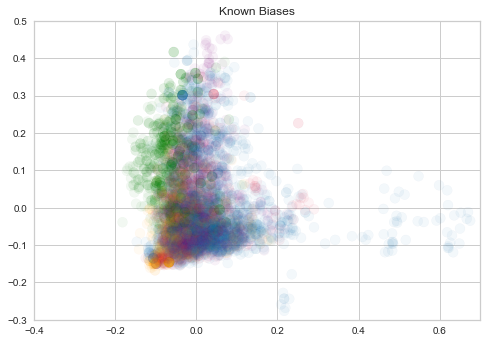

In [37]:
df_known_bias = df[df['bias'] != 4]

plt.title('Known Biases')
plt.xlim(-.4, .7)
plt.ylim(-.3,.5)
plt.scatter(df_known_bias.loc[:, ['principal component 1']], df_known_bias.loc[:, ['principal component 2']], 
                c = [color_bias_dict[str(i)] for i in df_known_bias['bias']],
                alpha=.05,
                s = 100
               )


## Known Bias Over Time

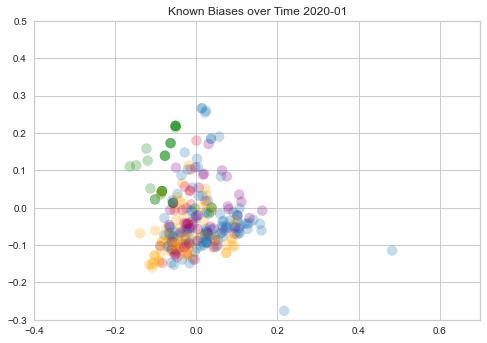

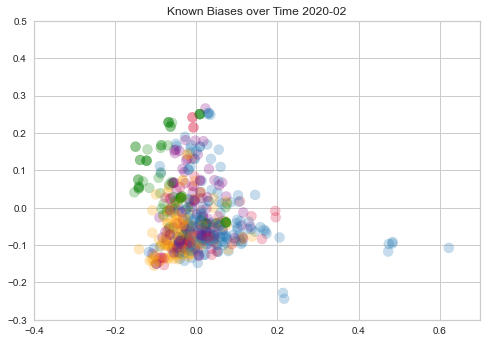

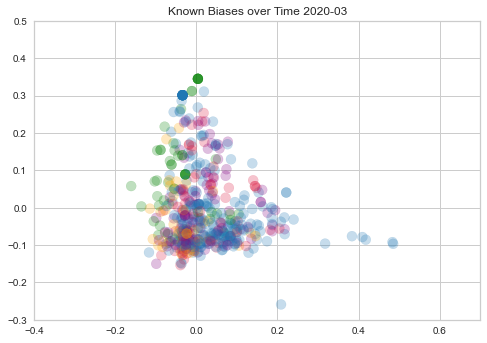

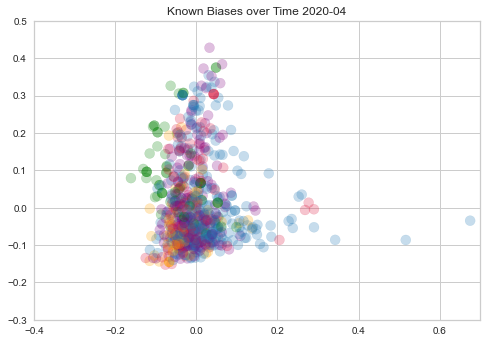

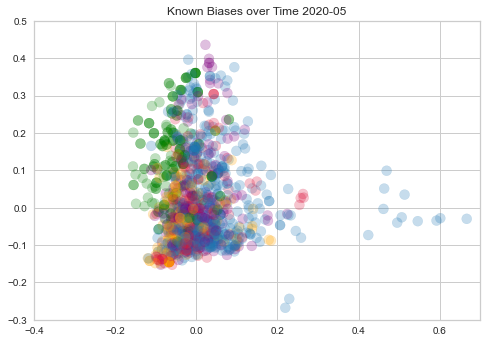

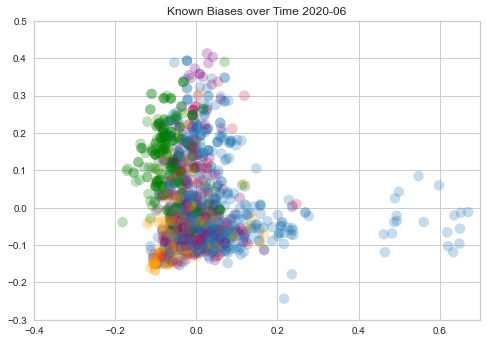

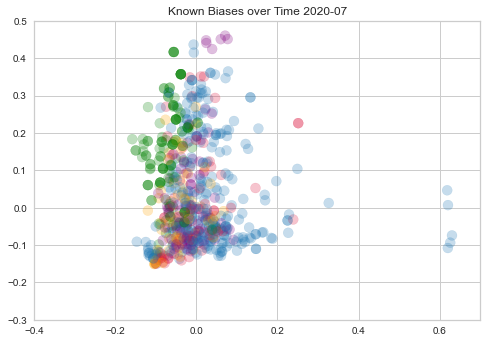

In [38]:
df_known_bias = df[df['bias'] != 4]
plot_over_time(df_known_bias, 'Known Biases over Time', alpha=0.25, 
               xval = (-.4, .7), yval = (-.3,.5),
               color_dict = color_bias_dict, color_by = 'bias',
               months_range = months_2020)

## Left vs Right Bias

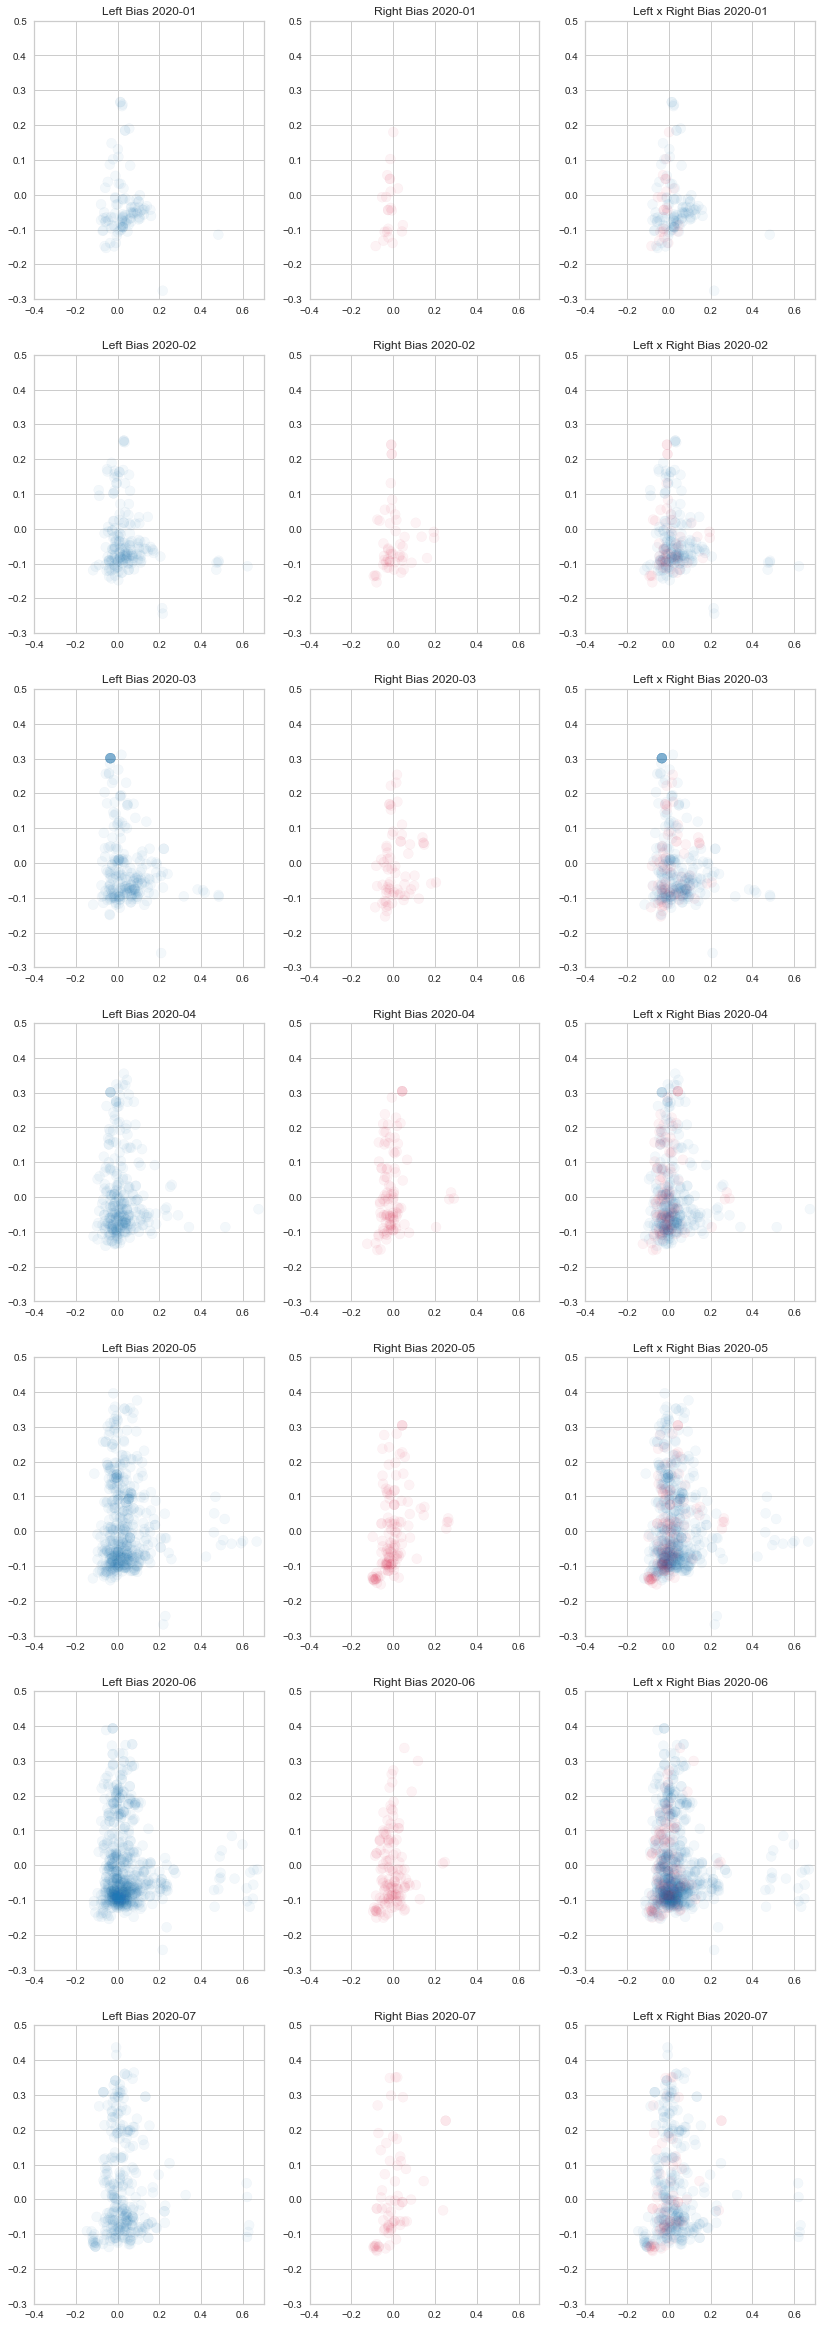

In [39]:
df_left = df[df['bias'] == 3]
df_right = df[df['bias'] == 5]
df_left_x_right = df[(df['bias'] == 5) | (df['bias'] == 3)]

plot_vs_group_over_time(df_left, df_right, df_left_x_right, 
                        "Left Bias", "Right Bias", "Left x Right Bias", 
                        alpha=0.05, xval = (-.4, .7), yval = (-.3,.5), 
                        color_dict = color_bias_dict, color_by = 'bias', 
                        months_range = months_2020)


## Right vs Conspiracy vs Fake News

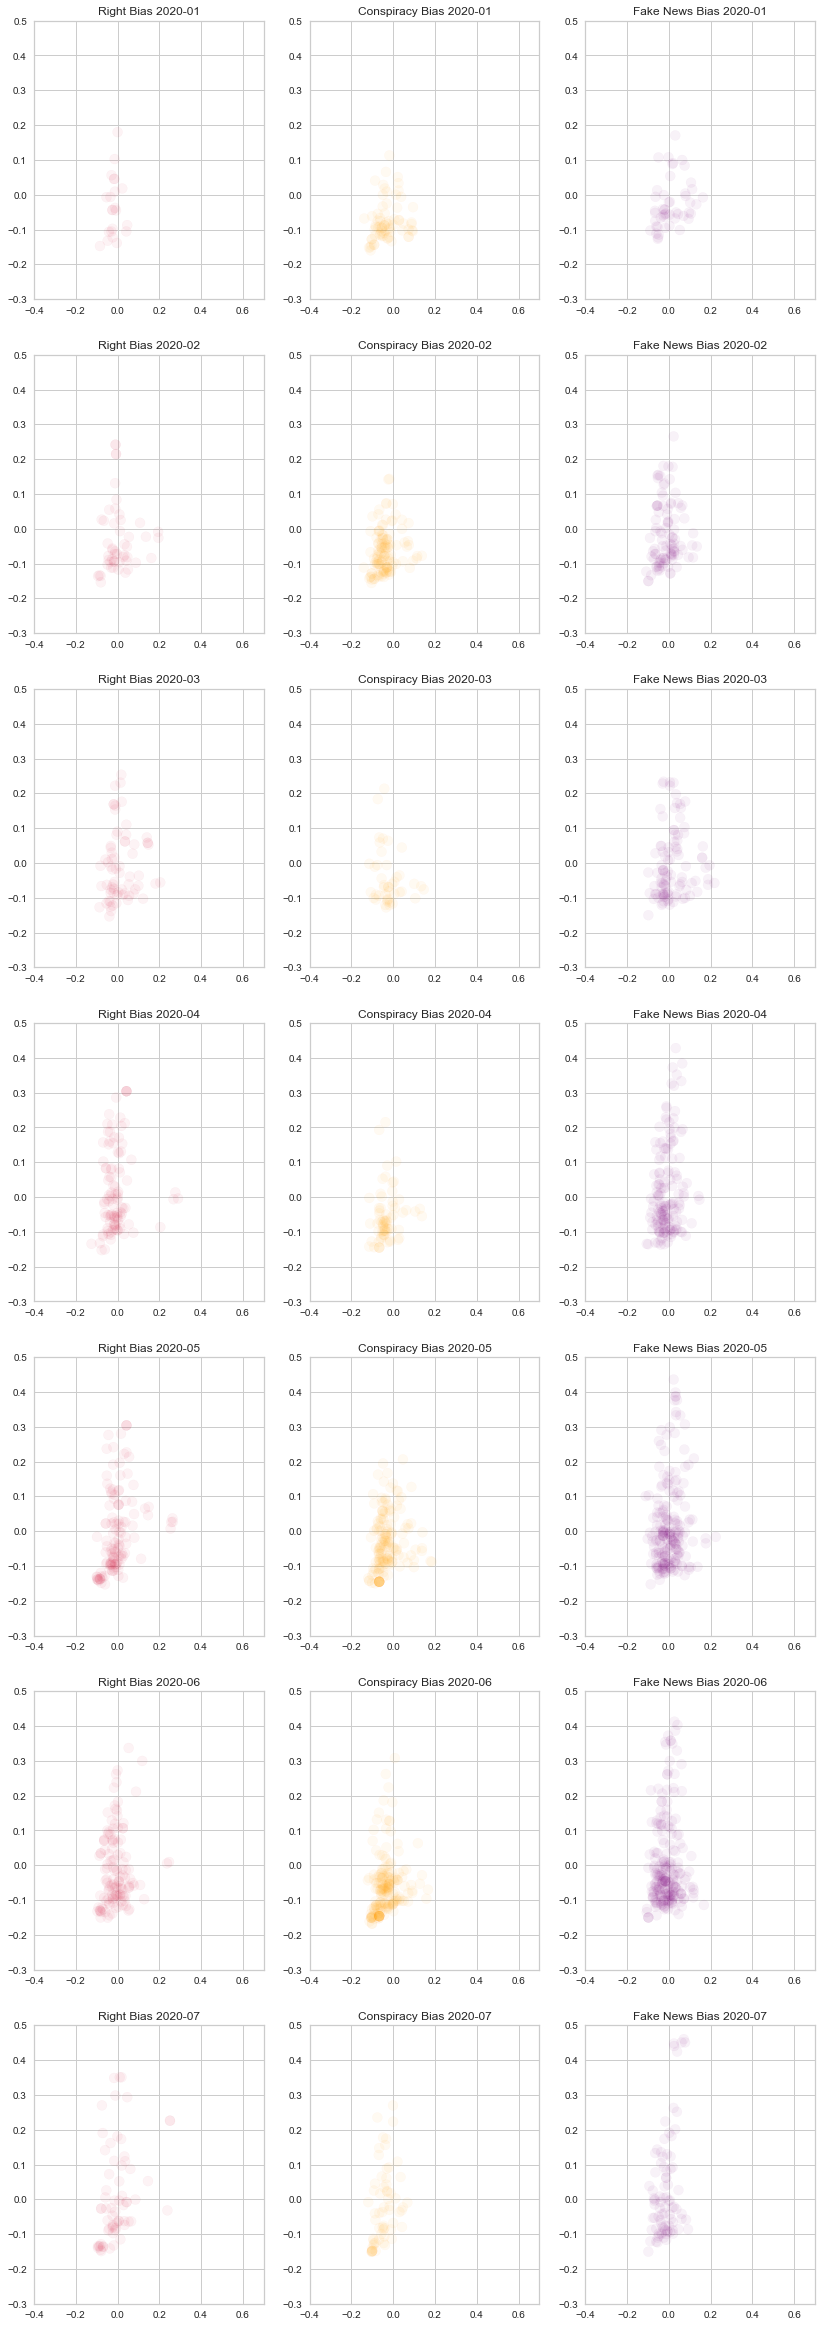

In [40]:
df_right = df[df['bias'] == 5]
df_conspiracy = df[df['bias'] == 0]
df_fake_news = df[df['bias'] == 1]

plot_vs_group_over_time(df_right, df_conspiracy, df_fake_news, 
                        "Right Bias", "Conspiracy Bias", "Fake News Bias", 
                        alpha=0.05, xval = (-.4, .7), yval = (-.3,.5), 
                        color_dict = color_bias_dict, color_by = 'bias', 
                        months_range = months_2020)


## Left vs Conspiracy vs Fake News

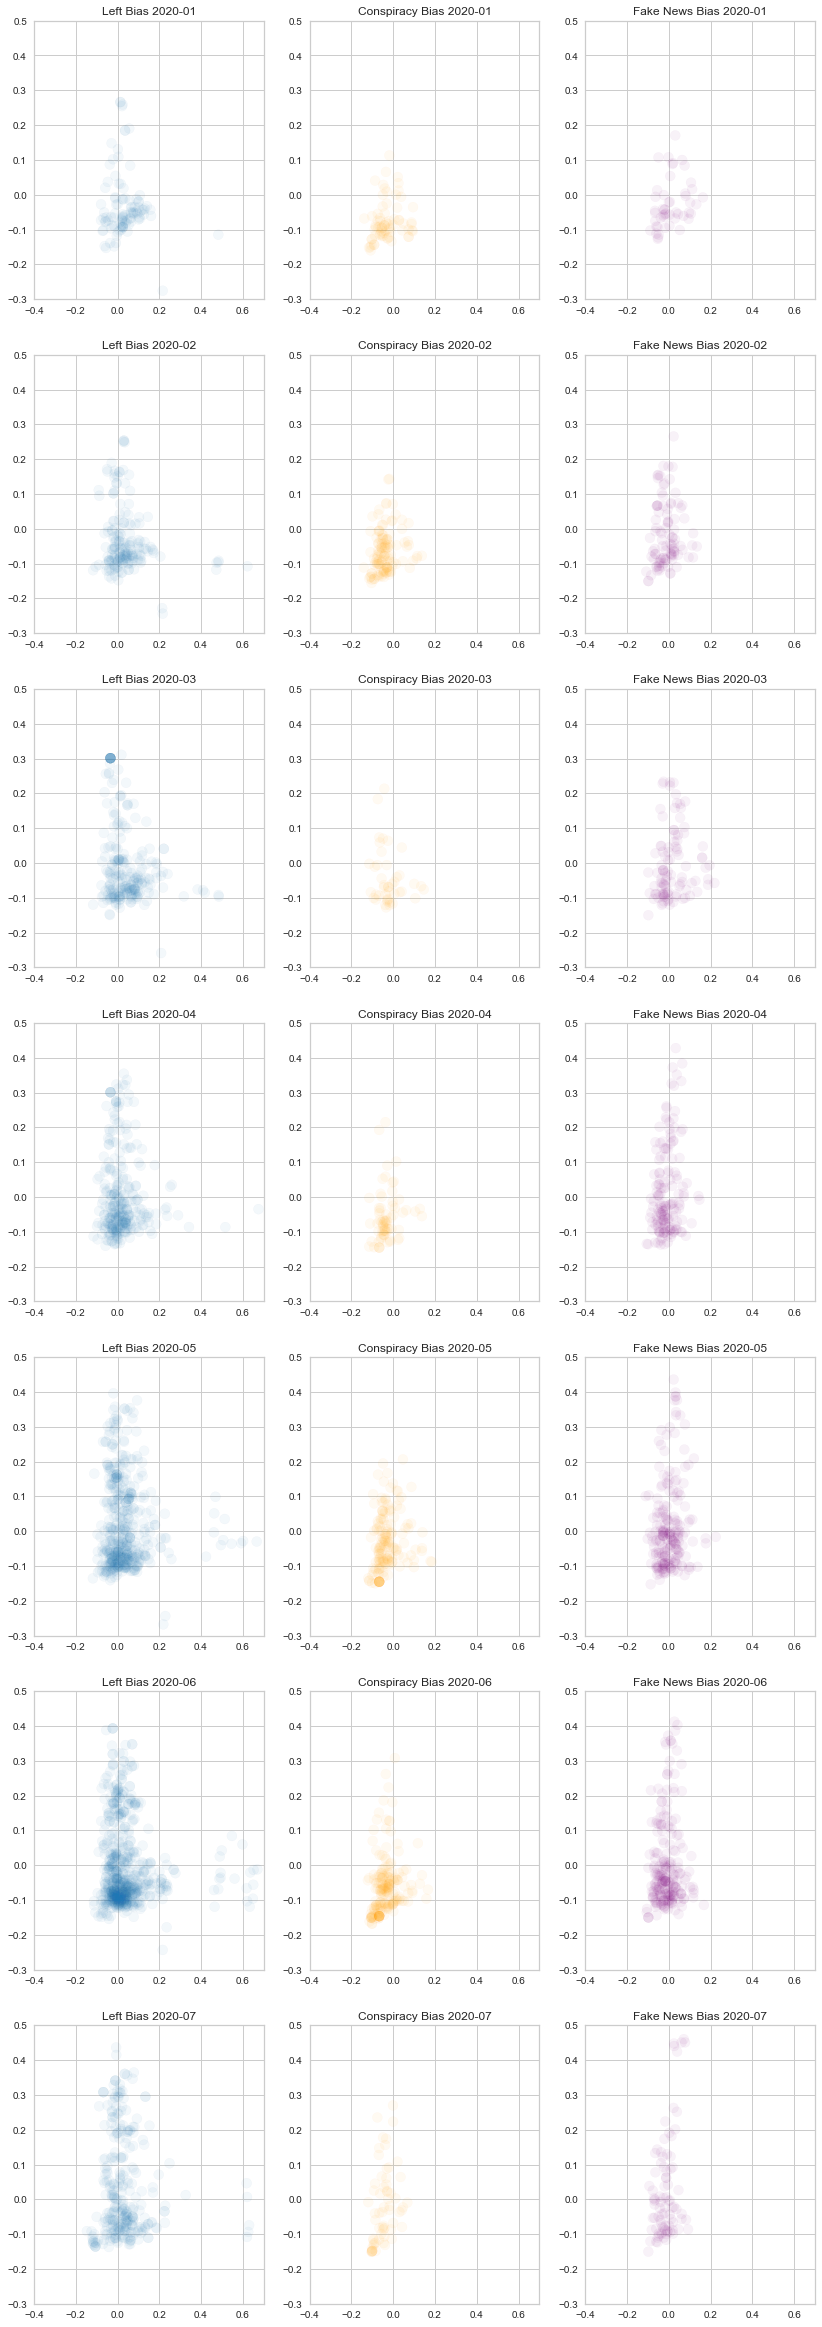

In [41]:
plot_vs_group_over_time(df_left, df_conspiracy, df_fake_news, 
                        "Left Bias", "Conspiracy Bias", "Fake News Bias", 
                        alpha=0.05, xval = (-.4, .7), yval = (-.3,.5), 
                        color_dict = color_bias_dict, color_by = 'bias', 
                        months_range = months_2020)